In [25]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory
import os
import sys
# Any results you write to the current directory are saved as output.

from datetime import datetime
from IPython.core.display import display, HTML
from matplotlib import pyplot    
import math
import csv
bln_create_df_all_csv_file = True
bln_create_words_csv_file = False
int_df_all_version = 6
bln_ready_to_commit = True
bln_create_estimate_files = False
bln_upload_input_estimates = False
bln_recode_variables = True
pd.set_option("display.max_rows", 101)
pd.set_option("display.max_columns", 25)

df_time_check = pd.DataFrame(columns=['Stage','Start','End', 'Seconds', 'Minutes'])
int_time_check = 0
dat_start = datetime.now()
dat_program_start = dat_start

if not bln_ready_to_commit:
    int_read_csv_rows = 100000
else:
    int_read_csv_rows= None
    
# generate crosstabs  {0 = nothing; 1 = screen}
int_important_crosstab = 1
int_past_crosstab = 0
int_current_crosstab = 1

str_text = "Please note that as I can't guarantee the accuracy of the information provided in this kernel, " + \
           "you use the information at your own risk. I'm only using some of the data provided in the Chicago Crime dataset. " + \
           "This kernel is under construction and subject to change at any time."
display(HTML('<p style="color:orange;">' + str_text + '</p>'))


In [26]:
def get_translations_analysis_description(df_input, str_language, str_group, int_code):
    # created by darryldias 25may2018
    df_temp = df_input[(df_input['language']==str_language) & (df_input['group']==str_group) & (df_input['code']==int_code)] \
                    ['description']
    return df_temp.iloc[0]

#translations_analysis = pd.read_csv('../input/ulabox-translations-analysis/translations_analysis.csv')
strg_count_column = 'count'   #get_translations_analysis_description(translations_analysis, str_language, 'special', 2)

def start_time_check():
    # created by darryldias 21may2018 - updated 8june2018
    global dat_start 
    dat_start = datetime.now()
    
def end_time_check(dat_start, str_stage):
    # created by darryldias 21may2018 - updated 8june2018
    global int_time_check
    global df_time_check
    int_time_check += 1
    dat_end = datetime.now()
    diff_seconds = (dat_end-dat_start).total_seconds()
    diff_minutes = diff_seconds / 60.0
    df_time_check.loc[int_time_check] = [str_stage, dat_start, dat_end, diff_seconds, diff_minutes]

def create_topline(df_input, str_item_column, str_count_column):
    # created by darryldias 21may2018; updated by darryldias 29may2018
    str_percent_column = 'percent'   #get_translations_analysis_description(translations_analysis, str_language, 'special', 3)
    df_temp = df_input.groupby(str_item_column).size().reset_index(name=str_count_column)
    df_output = pd.DataFrame(columns=[str_item_column, str_count_column, str_percent_column])
    int_rows = df_temp.shape[0]
    int_columns = df_temp.shape[1]
    int_total = df_temp[str_count_column].sum()
    flt_total = float(int_total)
    for i in range(int_rows):
        str_item = df_temp.iloc[i][0]
        int_count = df_temp.iloc[i][1]
        flt_percent = round(int_count / flt_total * 100, 1)
        df_output.loc[i] = [str_item, int_count, flt_percent]
    
    df_output.loc[int_rows] = ['total', int_total, 100.0]
    return df_output        

def get_size_raw(df_input):
    return sys.getsizeof(df_input)

def get_size_mb(df_input):
    int_size_raw = get_size_raw(df_input)
    flt_size = float(int_size_raw) / 1000000 
    return int(flt_size)

def get_dataframe_info(df_input, bln_output_csv = False, str_filename = None):
    # created by darryldias 24may2018 - updated 25jan2019
    int_rows = df_input.shape[0]
    int_cols = df_input.shape[1]
    flt_rows = float(int_rows)
    int_size_mb = get_size_mb(df_input)

    df_output = pd.DataFrame(columns=["Column", "Type", "Not Null", 'Null', '% Not Null', '% Null'])
    df_output.loc[0] = ['Table Row Count', '', int_rows, '', '', '']
    df_output.loc[1] = ['Table Column Count', '', int_cols, '', '', '']
    df_output.loc[2] = ['Table Size (MB)', '', int_size_mb, '', '', '']
    int_table_row = 2
    for i in range(int_cols):
        str_column_name = df_input.columns.values[i]
        str_column_type = df_input.dtypes.values[i]
        int_not_null = df_input[str_column_name].count()
        int_null = sum( pd.isnull(df_input[str_column_name]) )
        flt_percent_not_null = round(int_not_null / flt_rows * 100, 1)
        flt_percent_null = round(100 - flt_percent_not_null, 1)
        int_table_row += 1
        df_output.loc[int_table_row] = [str_column_name, str_column_type, int_not_null, int_null, flt_percent_not_null, flt_percent_null]

    if bln_output_csv:
        df_output.to_csv(str_filename)
        print ('Dataframe information output created in file: ' + str_filename)
        return None
    return df_output

def check_numeric_var(str_question, int_groups):
    # created by darryldias 3jul2018  
    #print(df_output.iloc[3][2])
    flt_min = application_all[str_question].min()
    flt_max = application_all[str_question].max()
    flt_range = flt_max - flt_min 
    flt_interval = flt_range / int_groups 
    df_output = pd.DataFrame(columns=['interval', 'value', 'count', 'percent', 'code1', 'code2'])

    int_total = application_all[ (application_all[str_question] <= flt_max) ][str_question].count()
    for i in range(0, int_groups + 1):
        flt_curr_interval = i * flt_interval
        flt_value = flt_min + flt_curr_interval
        int_count = application_all[ (application_all[str_question] <= flt_value) ][str_question].count()
        flt_percent = int_count /  int_total * 100.0
        str_code_value = "{0:.6f}".format(flt_value)
        str_code1 = "if row['" + str_question + "'] <= " + str_code_value + ":"
        str_code2 = "return '(x to " + str_code_value + "]'"
        df_output.loc[i] = [flt_curr_interval, flt_value, int_count, flt_percent, str_code1, str_code2]

    return df_output

def show_folder_items(str_folder):
    # darryldias 8jan2019
    df_return = pd.DataFrame(columns=['Folder', 'Item'])
    lst_items = sorted( os.listdir(str_folder) )
    int_row = 0
    for str_item in lst_items:
        int_row += 1
        df_return.loc[int_row] = [str_folder, str_item]
    
    return df_return


In [27]:
def get_column_analysis(int_analysis, int_code):
    # created by darryldias 24jul2018 
    if int_code == 1:
        return ['overall', 'homicide yes', 'homicide no', 'may18', 'jun18', 'jul18', 'aug18', 'sep18', 'oct18', \
                 'nov18', 'dec18', 'jan19', 'feb19', 'mar19', 'apr19']
    elif int_code == 2:
        return ['overall', 'is_homicide', 'is_homicide', 'date_ym', 'date_ym', 'date_ym', 'date_ym', 'date_ym', 'date_ym', \
                 'date_ym', 'date_ym', 'date_ym', 'date_ym', 'date_ym', 'date_ym']
    elif int_code == 3:
        return [1, 1, 0, 201805, 201806, 201807, 201808, 201809, 201810, 201811, 201812, 201901, 201902, 201903, 201904]
    else:
        return None

def create_crosstab_type1(df_input, str_row_question, int_output_destination):
    # created by darryldias 10jun2018 - updated 27sep2018 
    # got some useful code from:
    # https://chrisalbon.com/python/data_wrangling/pandas_missing_data/
    # https://www.tutorialspoint.com/python/python_lists.htm
    # https://stackoverflow.com/questions/455612/limiting-floats-to-two-decimal-points

    if int_output_destination == 0:
        return None
    
    str_count_desc = 'count'  #get_translations_analysis_description(translations_analysis, str_language, 'special', 3)
    str_colpercent_desc = 'col percent'
    
    list_str_column_desc = get_column_analysis(1, 1)
    list_str_column_question = get_column_analysis(1, 2)
    list_str_column_category = get_column_analysis(1, 3)
    int_columns = len(list_str_column_desc)
    list_int_column_base = []
    list_flt_column_base_percent = []
    
    df_group = df_input.groupby(str_row_question).size().reset_index(name='count')
    int_rows = df_group.shape[0]

    for j in range(int_columns):
        int_count = df_input[ df_input[str_row_question].notnull() & (df_input[list_str_column_question[j]]==list_str_column_category[j]) ] \
                                [list_str_column_question[j]].count()
        list_int_column_base.append(int_count)
        if int_count == 0:
            list_flt_column_base_percent.append('')
        else:
            list_flt_column_base_percent.append('100.0')
        
    list_output = []
    list_output.append('row_question')
    list_output.append('row_category')
    list_output.append('statistic')
    for k in range(1, int_columns+1):
        str_temp = 'c' + str(k)
        list_output.append(str_temp)
    df_output = pd.DataFrame(columns=list_output)

    int_row = 1
    list_output = []
    list_output.append(str_row_question)
    list_output.append('')
    list_output.append('')
    for k in range(int_columns):
        list_output.append(list_str_column_desc[k])
    df_output.loc[int_row] = list_output
    
    int_row = 2
    list_output = []
    list_output.append(str_row_question)
    list_output.append('total')
    list_output.append(str_count_desc)
    for k in range(int_columns):
        list_output.append(list_int_column_base[k])
    df_output.loc[int_row] = list_output
    
    int_row = 3
    list_output = []
    list_output.append(str_row_question)
    list_output.append('total')
    list_output.append(str_colpercent_desc)
    for k in range(int_columns):
        list_output.append(list_flt_column_base_percent[k])
    df_output.loc[int_row] = list_output

    for i in range(int_rows):
        int_row += 1
        int_count_row = int_row
        int_row += 1
        int_colpercent_row = int_row

        str_row_category = df_group.iloc[i][0]

        list_int_column_count = []
        list_flt_column_percent = []
        for j in range(int_columns):
            int_count = df_input[ (df_input[str_row_question]==str_row_category) & \
                                  (df_input[list_str_column_question[j]]==list_str_column_category[j]) ] \
                                [list_str_column_question[j]].count()
            list_int_column_count.append(int_count)
            flt_base = float(list_int_column_base[j])
            if flt_base > 0:
                flt_percent = round(100 * int_count / flt_base,1)
                str_percent = "{0:.1f}".format(flt_percent)
            else:
                str_percent = ''
            list_flt_column_percent.append(str_percent)
        
        list_output = []
        list_output.append(str_row_question)
        list_output.append(str_row_category)
        list_output.append(str_count_desc)
        for k in range(int_columns):
            list_output.append(list_int_column_count[k])
        df_output.loc[int_count_row] = list_output
        
        list_output = []
        list_output.append(str_row_question)
        list_output.append(str_row_category)
        list_output.append(str_colpercent_desc)
        for k in range(int_columns):
            list_output.append(list_flt_column_percent[k])
        df_output.loc[int_colpercent_row] = list_output
        
    return df_output        

def get_ct_statistic2(df_input, str_row_question, str_col_question, str_col_category, str_statistic):
    # created by darryldias 17jul2018
    if str_statistic == 'total':
        int_temp = df_input[ (df_input[str_col_question] == str_col_category) ][str_row_question].isnull().count() 
    elif str_statistic == 'notnull':
        int_temp = df_input[ (df_input[str_col_question] == str_col_category) ][str_row_question].count() 
    elif str_statistic == 'null':
        int_temp = df_input[ (df_input[str_col_question] == str_col_category) ][str_row_question].isnull().sum() 
    elif str_statistic == 'mean':
        int_temp = df_input[ (df_input[str_col_question] == str_col_category) ][str_row_question].mean() 
    elif str_statistic == 'median':
        int_temp = df_input[ (df_input[str_col_question] == str_col_category) ][str_row_question].median() 
    elif str_statistic == 'minimum':
        int_temp = df_input[ (df_input[str_col_question] == str_col_category) ][str_row_question].min() 
    elif str_statistic == 'maximum':
        int_temp = df_input[ (df_input[str_col_question] == str_col_category) ][str_row_question].max() 
    else:
        int_temp = None
    return int_temp
 
def create_crosstab_type2(df_input, str_row_question, int_output_destination):
    # created by darryldias 24jul2018
    if int_output_destination == 0:
        return None

    list_str_column_desc = get_column_analysis(1, 1)
    list_str_column_question = get_column_analysis(1, 2)
    list_str_column_category = get_column_analysis(1, 3)
    int_analysis_columns = len(list_str_column_question)

    list_str_statistics = ['total', 'notnull', 'null', 'mean', 'median', 'minimum', 'maximum']
    list_str_counts = ['total', 'notnull', 'null']
    int_statistics = len(list_str_statistics)

    df_output = pd.DataFrame(columns=['row_question', 'row_category', 'statistic', 'c1', 'c2', 'c3', 'c4', 'c5'])
    int_row = 1

    list_values = []
    list_values.append(str_row_question)
    list_values.append('')
    list_values.append('')
    for j in range(int_analysis_columns):
        list_values.append(list_str_column_desc[j])
    df_output.loc[int_row] = list_values

    for i in range(int_statistics):
        str_statistic = list_str_statistics[i] 
        list_values = []
        list_values.append(str_row_question)
        if str_statistic in list_str_counts:
            list_values.append(str_statistic)
            list_values.append('count')
        else:
            list_values.append('numeric')
            list_values.append(str_statistic)
    
        for j in range(int_analysis_columns):
            str_col_question = list_str_column_question[j]
            str_col_category = list_str_column_category[j]
            num_statistic = get_ct_statistic2(df_input, str_row_question, str_col_question, str_col_category, str_statistic)
            list_values.append(num_statistic)
        int_row += 1
        df_output.loc[int_row] = list_values
    return df_output


In [28]:
def percent_summary_1 (row, str_input_column):
    # created by darryldias 27may2018   
    if row[str_input_column] == 0 :   
        return 'no'
    elif row[str_input_column] > 0 :
        return 'yes'
    return 'Unknown'

def get_note(id):
    df_temp = df_notes[ df_notes['id']==id ]
    return df_temp.iloc[0][1]

def get_html_table():
    str_return = ''
    int_column_html = 1
    df_html_tables = pd.read_csv('../input/chicago-crime/html_tables.csv', nrows=int_read_csv_rows)
    str_return = df_html_tables.iloc[0][int_column_html] + '\n'
    str_return = str_return + df_html_tables.iloc[1][int_column_html] + '\n'
    str_return = str_return + df_html_tables.iloc[2][int_column_html] + '\n'
    str_return = str_return + df_html_tables.iloc[3][int_column_html] 
    return str_return


df_notes = pd.read_csv('../input/chicago-crime/notes.csv', nrows=int_read_csv_rows)

str_note1 = get_note(1)
str_note2 = get_note(2)
display(HTML('<h4 style="color:purple;">' + str_note1 + ' - ' + str_note2 + '</h4>'))


### homicides per day

may18,jun18,jul18,aug18,sep18,oct18,nov18,dec18,jan19,feb19,mar19,apr19
1.7,1.9,2.0,1.9,1.8,1.7,1.5,1.4,0.7,0.8,1.1,1.9


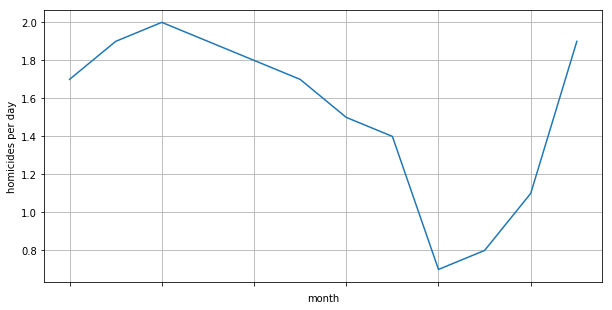

In [29]:
str_note = get_note(3)
display(HTML('<h4 style="color:purple;">' + str_note + '</h4>'))

str_html_table = get_html_table()
#print(str_html_table)
display(HTML(str_html_table))

df_table1 = pd.read_csv('../input/chicago-crime/table1.csv', nrows=int_read_csv_rows)
plot_temp = df_table1.plot(x='column', y='value', figsize=(10, 5), legend=None)
pyplot.xlabel('month')
pyplot.ylabel('homicides per day')
pyplot.grid()


### datasets

In [30]:
# a bug in the system
show_folder_items('../input/chicago-crime')

,Folder,Item
1,../input/chicago-crime,crime.csv
2,../input/chicago-crime,date_ym_col.csv
3,../input/chicago-crime,district.csv
4,../input/chicago-crime,html_tables.csv
5,../input/chicago-crime,notes.csv
6,../input/chicago-crime,table1.csv


In [31]:
df_crime = pd.read_csv('../input/chicago-crime/crime.csv', nrows=int_read_csv_rows)
df_crime.sample(10)

,unique_key,date,year,month,day,day_of_week,hour,date_ym,date_ymd,primary_type,arrest,domestic,district,location_description,district_s1d,overall,is_homicide,day_of_week_s1d,hour_s1d,primary_type_s1d,location_description_s1d
127758,11395421,2018-07-28 19:25:00+00:00,2018,7,28,7,19,201807,20180728,NARCOTICS,True,False,11,STREET,Harrison,1,0,Saturday,16-19,NARCOTICS,STREET
242051,11496654,2018-11-03 12:36:00+00:00,2018,11,3,7,12,201811,20181103,ASSAULT,False,True,22,RESIDENCE,Morgan Park,1,0,Saturday,12-15,ASSAULT,OTHER
214457,11491512,2018-10-29 17:32:00+00:00,2018,10,29,2,17,201810,20181029,CRIMINAL DAMAGE,False,False,6,SIDEWALK,Gresham,1,0,Monday,16-19,CRIMINAL DAMAGE,OTHER
2030,11574725,2019-01-23 08:00:00+00:00,2019,1,23,4,8,201901,20190123,NARCOTICS,True,False,11,ABANDONED BUILDING,Harrison,1,0,Wednesday,08-11,NARCOTICS,OTHER
27982,11609330,2019-02-28 08:30:00+00:00,2019,2,28,5,8,201902,20190228,OTHER OFFENSE,False,True,22,RESIDENCE,Morgan Park,1,0,Thursday,08-11,OTHER,OTHER
240768,11514245,2018-11-22 09:20:00+00:00,2018,11,22,5,9,201811,20181122,BATTERY,False,True,4,RESIDENCE,South Chicago,1,0,Thursday,08-11,BATTERY,OTHER
199648,11488981,2018-10-27 04:33:00+00:00,2018,10,27,7,4,201810,20181027,BURGLARY,False,False,24,COMMERCIAL / BUSINESS OFFICE,Rogers Park,1,0,Saturday,04-07,BURGLARY,OTHER
199621,11481688,2018-10-18 08:30:00+00:00,2018,10,18,5,8,201810,20181018,MOTOR VEHICLE THEFT,False,True,24,STREET,Rogers Park,1,0,Thursday,08-11,MOTOR VEHICLE THEFT,STREET
110697,11346730,2018-06-13 18:25:00+00:00,2018,6,13,4,18,201806,20180613,NARCOTICS,True,False,10,VACANT LOT/LAND,Ogden,1,0,Wednesday,16-19,NARCOTICS,OTHER
170525,11413526,2018-08-13 07:30:00+00:00,2018,8,13,2,7,201808,20180813,ASSAULT,False,True,24,RESIDENTIAL YARD (FRONT/BACK),Rogers Park,1,0,Monday,04-07,ASSAULT,OTHER


In [32]:
get_dataframe_info(df_crime)

,Column,Type,Not Null,Null,% Not Null,% Null
0,Table Row Count,,263934,,,
1,Table Column Count,,21,,,
2,Table Size (MB),,165,,,
3,unique_key,int64,263934,0,100,0
4,date,object,263934,0,100,0
5,year,int64,263934,0,100,0
6,month,int64,263934,0,100,0
7,day,int64,263934,0,100,0
8,day_of_week,int64,263934,0,100,0
9,hour,int64,263934,0,100,0


### overall

In [33]:
create_crosstab_type1(df_crime, 'overall', int_important_crosstab)

,row_question,row_category,statistic,c1,c2,c3,c4,c5,c6,c7,c8,c9,c10,c11,c12,c13,c14,c15
1,overall,,,overall,homicide yes,homicide no,may18,jun18,jul18,aug18,sep18,oct18,nov18,dec18,jan19,feb19,mar19,apr19
2,overall,total,count,263934,565,263369,24622,24094,25117,25271,22843,22628,20465,21743,19131,17984,19938,20098
3,overall,total,col percent,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0
4,overall,1,count,263934,565,263369,24622,24094,25117,25271,22843,22628,20465,21743,19131,17984,19938,20098
5,overall,1,col percent,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0


In [34]:
create_crosstab_type1(df_crime, 'year', int_current_crosstab)

,row_question,row_category,statistic,c1,c2,c3,c4,c5,c6,c7,c8,c9,c10,c11,c12,c13,c14,c15
1,year,,,overall,homicide yes,homicide no,may18,jun18,jul18,aug18,sep18,oct18,nov18,dec18,jan19,feb19,mar19,apr19
2,year,total,count,263934,565,263369,24622,24094,25117,25271,22843,22628,20465,21743,19131,17984,19938,20098
3,year,total,col percent,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0
4,year,2018,count,186783,428,186355,24622,24094,25117,25271,22843,22628,20465,21743,0,0,0,0
5,year,2018,col percent,70.8,75.8,70.8,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,0.0,0.0,0.0,0.0
6,year,2019,count,77151,137,77014,0,0,0,0,0,0,0,0,19131,17984,19938,20098
7,year,2019,col percent,29.2,24.2,29.2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,100.0,100.0,100.0,100.0


In [35]:
create_crosstab_type1(df_crime, 'month', int_current_crosstab)

,row_question,row_category,statistic,c1,c2,c3,c4,c5,c6,c7,c8,c9,c10,c11,c12,c13,c14,c15
1,month,,,overall,homicide yes,homicide no,may18,jun18,jul18,aug18,sep18,oct18,nov18,dec18,jan19,feb19,mar19,apr19
2,month,total,count,263934,565,263369,24622,24094,25117,25271,22843,22628,20465,21743,19131,17984,19938,20098
3,month,total,col percent,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0
4,month,1,count,19131,21,19110,0,0,0,0,0,0,0,0,19131,0,0,0
5,month,1,col percent,7.2,3.7,7.3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,100.0,0.0,0.0,0.0
6,month,2,count,17984,23,17961,0,0,0,0,0,0,0,0,0,17984,0,0
7,month,2,col percent,6.8,4.1,6.8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,100.0,0.0,0.0
8,month,3,count,19938,35,19903,0,0,0,0,0,0,0,0,0,0,19938,0
9,month,3,col percent,7.6,6.2,7.6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,100.0,0.0
10,month,4,count,20098,58,20040,0,0,0,0,0,0,0,0,0,0,0,20098


In [36]:
create_crosstab_type1(df_crime, 'day', int_current_crosstab)

,row_question,row_category,statistic,c1,c2,c3,c4,c5,c6,c7,c8,c9,c10,c11,c12,c13,c14,c15
1,day,,,overall,homicide yes,homicide no,may18,jun18,jul18,aug18,sep18,oct18,nov18,dec18,jan19,feb19,mar19,apr19
2,day,total,count,263934,565,263369,24622,24094,25117,25271,22843,22628,20465,21743,19131,17984,19938,20098
3,day,total,col percent,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0
4,day,1,count,10158,21,10137,974,965,951,901,928,872,888,767,875,685,664,688
5,day,1,col percent,3.8,3.7,3.8,4.0,4.0,3.8,3.6,4.1,3.9,4.3,3.5,4.6,3.8,3.3,3.4
6,day,2,count,8927,21,8906,787,819,859,850,810,713,774,708,640,700,641,626
7,day,2,col percent,3.4,3.7,3.4,3.2,3.4,3.4,3.4,3.5,3.2,3.8,3.3,3.3,3.9,3.2,3.1
8,day,3,count,8778,29,8749,738,835,819,890,764,671,776,765,740,588,535,657
9,day,3,col percent,3.3,5.1,3.3,3.0,3.5,3.3,3.5,3.3,3.0,3.8,3.5,3.9,3.3,2.7,3.3
10,day,4,count,8875,13,8862,814,788,825,899,806,694,682,715,750,724,536,642


In [37]:
create_crosstab_type1(df_crime, 'primary_type_s1d', int_current_crosstab)

,row_question,row_category,statistic,c1,c2,c3,c4,c5,c6,c7,c8,c9,c10,c11,c12,c13,c14,c15
1,primary_type_s1d,,,overall,homicide yes,homicide no,may18,jun18,jul18,aug18,sep18,oct18,nov18,dec18,jan19,feb19,mar19,apr19
2,primary_type_s1d,total,count,263934,565,263369,24622,24094,25117,25271,22843,22628,20465,21743,19131,17984,19938,20098
3,primary_type_s1d,total,col percent,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0
4,primary_type_s1d,ASSAULT,count,20580,0,20580,2035,1877,1942,1847,1811,1716,1540,1588,1452,1415,1657,1700
5,primary_type_s1d,ASSAULT,col percent,7.8,0.0,7.8,8.3,7.8,7.7,7.3,7.9,7.6,7.5,7.3,7.6,7.9,8.3,8.5
6,primary_type_s1d,BATTERY,count,50092,0,50092,4978,4639,4883,4614,4349,4298,3635,3855,3511,3339,4042,3949
7,primary_type_s1d,BATTERY,col percent,19.0,0.0,19.0,20.2,19.3,19.4,18.3,19.0,19.0,17.8,17.7,18.4,18.6,20.3,19.6
8,primary_type_s1d,BURGLARY,count,11129,0,11129,973,1062,1139,1214,1051,1002,913,967,793,667,667,681
9,primary_type_s1d,BURGLARY,col percent,4.2,0.0,4.2,4.0,4.4,4.5,4.8,4.6,4.4,4.5,4.4,4.1,3.7,3.3,3.4
10,primary_type_s1d,CRIMINAL DAMAGE,count,27410,0,27410,2669,2588,2725,2635,2287,2521,1966,2243,1787,1713,2016,2260


In [38]:
create_crosstab_type1(df_crime, 'district_s1d', int_current_crosstab)

,row_question,row_category,statistic,c1,c2,c3,c4,c5,c6,c7,c8,c9,c10,c11,c12,c13,c14,c15
1,district_s1d,,,overall,homicide yes,homicide no,may18,jun18,jul18,aug18,sep18,oct18,nov18,dec18,jan19,feb19,mar19,apr19
2,district_s1d,total,count,263934,565,263369,24622,24094,25117,25271,22843,22628,20465,21743,19131,17984,19938,20098
3,district_s1d,total,col percent,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0
4,district_s1d,Albany Park,count,7217,9,7208,688,669,677,646,588,661,568,674,515,484,492,555
5,district_s1d,Albany Park,col percent,2.7,1.6,2.7,2.8,2.8,2.7,2.6,2.6,2.9,2.8,3.1,2.7,2.7,2.5,2.8
6,district_s1d,Austin,count,9991,39,9952,1001,889,1007,917,836,813,743,783,710,639,825,828
7,district_s1d,Austin,col percent,3.8,6.9,3.8,4.1,3.7,4.0,3.6,3.7,3.6,3.6,3.6,3.7,3.6,4.1,4.1
8,district_s1d,Calumet,count,11721,59,11662,1140,1173,1134,1144,983,964,872,958,841,759,852,901
9,district_s1d,Calumet,col percent,4.4,10.4,4.4,4.6,4.9,4.5,4.5,4.3,4.3,4.3,4.4,4.4,4.2,4.3,4.5
10,district_s1d,Central,count,15418,10,15408,1469,1380,1385,1573,1268,1269,1142,1327,1158,1107,1164,1176


### homicides

In [39]:
df_crime = df_crime[ (df_crime['is_homicide'] == 1) ]
create_crosstab_type1(df_crime, 'day_of_week_s1d', int_current_crosstab)

,row_question,row_category,statistic,c1,c2,c3,c4,c5,c6,c7,c8,c9,c10,c11,c12,c13,c14,c15
1,day_of_week_s1d,,,overall,homicide yes,homicide no,may18,jun18,jul18,aug18,sep18,oct18,nov18,dec18,jan19,feb19,mar19,apr19
2,day_of_week_s1d,total,count,565,565,0,53,57,62,58,54,54,46,44,21,23,35,58
3,day_of_week_s1d,total,col percent,100.0,100.0,,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0
4,day_of_week_s1d,Friday,count,87,87,0,11,10,8,11,7,5,10,3,5,2,8,7
5,day_of_week_s1d,Friday,col percent,15.4,15.4,,20.8,17.5,12.9,19.0,13.0,9.3,21.7,6.8,23.8,8.7,22.9,12.1
6,day_of_week_s1d,Monday,count,87,87,0,7,6,4,8,8,12,8,13,3,1,2,15
7,day_of_week_s1d,Monday,col percent,15.4,15.4,,13.2,10.5,6.5,13.8,14.8,22.2,17.4,29.5,14.3,4.3,5.7,25.9
8,day_of_week_s1d,Saturday,count,79,79,0,6,10,10,6,8,9,4,5,5,4,4,8
9,day_of_week_s1d,Saturday,col percent,14.0,14.0,,11.3,17.5,16.1,10.3,14.8,16.7,8.7,11.4,23.8,17.4,11.4,13.8
10,day_of_week_s1d,Sunday,count,106,106,0,8,13,15,12,12,7,5,8,2,7,9,8


In [40]:
create_crosstab_type1(df_crime, 'hour_s1d', int_current_crosstab)

,row_question,row_category,statistic,c1,c2,c3,c4,c5,c6,c7,c8,c9,c10,c11,c12,c13,c14,c15
1,hour_s1d,,,overall,homicide yes,homicide no,may18,jun18,jul18,aug18,sep18,oct18,nov18,dec18,jan19,feb19,mar19,apr19
2,hour_s1d,total,count,565,565,0,53,57,62,58,54,54,46,44,21,23,35,58
3,hour_s1d,total,col percent,100.0,100.0,,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0
4,hour_s1d,00-03,count,115,115,0,14,15,11,11,3,12,8,12,4,6,11,8
5,hour_s1d,00-03,col percent,20.4,20.4,,26.4,26.3,17.7,19.0,5.6,22.2,17.4,27.3,19.0,26.1,31.4,13.8
6,hour_s1d,04-07,count,52,52,0,4,8,9,7,4,5,2,4,1,2,2,4
7,hour_s1d,04-07,col percent,9.2,9.2,,7.5,14.0,14.5,12.1,7.4,9.3,4.3,9.1,4.8,8.7,5.7,6.9
8,hour_s1d,08-11,count,65,65,0,3,5,3,10,7,9,8,6,2,1,2,9
9,hour_s1d,08-11,col percent,11.5,11.5,,5.7,8.8,4.8,17.2,13.0,16.7,17.4,13.6,9.5,4.3,5.7,15.5
10,hour_s1d,12-15,count,94,94,0,9,8,9,9,9,5,9,11,6,4,7,8


In [41]:
create_crosstab_type1(df_crime, 'district_s1d', int_current_crosstab)

,row_question,row_category,statistic,c1,c2,c3,c4,c5,c6,c7,c8,c9,c10,c11,c12,c13,c14,c15
1,district_s1d,,,overall,homicide yes,homicide no,may18,jun18,jul18,aug18,sep18,oct18,nov18,dec18,jan19,feb19,mar19,apr19
2,district_s1d,total,count,565,565,0,53,57,62,58,54,54,46,44,21,23,35,58
3,district_s1d,total,col percent,100.0,100.0,,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0
4,district_s1d,Albany Park,count,9,9,0,0,1,0,2,1,1,1,0,1,1,1,0
5,district_s1d,Albany Park,col percent,1.6,1.6,,0.0,1.8,0.0,3.4,1.9,1.9,2.2,0.0,4.8,4.3,2.9,0.0
6,district_s1d,Austin,count,39,39,0,7,1,4,1,4,3,5,2,0,3,4,5
7,district_s1d,Austin,col percent,6.9,6.9,,13.2,1.8,6.5,1.7,7.4,5.6,10.9,4.5,0.0,13.0,11.4,8.6
8,district_s1d,Calumet,count,59,59,0,1,8,8,7,4,9,7,4,1,0,2,8
9,district_s1d,Calumet,col percent,10.4,10.4,,1.9,14.0,12.9,12.1,7.4,16.7,15.2,9.1,4.8,0.0,5.7,13.8
10,district_s1d,Central,count,10,10,0,1,0,0,1,1,2,3,0,1,0,0,1


In [42]:
create_crosstab_type1(df_crime, 'arrest', int_current_crosstab)

,row_question,row_category,statistic,c1,c2,c3,c4,c5,c6,c7,c8,c9,c10,c11,c12,c13,c14,c15
1,arrest,,,overall,homicide yes,homicide no,may18,jun18,jul18,aug18,sep18,oct18,nov18,dec18,jan19,feb19,mar19,apr19
2,arrest,total,count,565,565,0,53,57,62,58,54,54,46,44,21,23,35,58
3,arrest,total,col percent,100.0,100.0,,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0
4,arrest,False,count,446,446,0,41,45,47,42,44,43,33,31,16,19,30,55
5,arrest,False,col percent,78.9,78.9,,77.4,78.9,75.8,72.4,81.5,79.6,71.7,70.5,76.2,82.6,85.7,94.8
6,arrest,True,count,119,119,0,12,12,15,16,10,11,13,13,5,4,5,3
7,arrest,True,col percent,21.1,21.1,,22.6,21.1,24.2,27.6,18.5,20.4,28.3,29.5,23.8,17.4,14.3,5.2


In [43]:
create_crosstab_type1(df_crime, 'domestic', int_current_crosstab)

,row_question,row_category,statistic,c1,c2,c3,c4,c5,c6,c7,c8,c9,c10,c11,c12,c13,c14,c15
1,domestic,,,overall,homicide yes,homicide no,may18,jun18,jul18,aug18,sep18,oct18,nov18,dec18,jan19,feb19,mar19,apr19
2,domestic,total,count,565,565,0,53,57,62,58,54,54,46,44,21,23,35,58
3,domestic,total,col percent,100.0,100.0,,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0
4,domestic,False,count,523,523,0,49,55,60,52,54,50,37,38,18,22,32,56
5,domestic,False,col percent,92.6,92.6,,92.5,96.5,96.8,89.7,100.0,92.6,80.4,86.4,85.7,95.7,91.4,96.6
6,domestic,True,count,42,42,0,4,2,2,6,0,4,9,6,3,1,3,2
7,domestic,True,col percent,7.4,7.4,,7.5,3.5,3.2,10.3,0.0,7.4,19.6,13.6,14.3,4.3,8.6,3.4


### other notes
* district names were obtained from [https://home.chicagopolice.org/community/districts/](https://home.chicagopolice.org/community/districts/)
* I am running a bigquery extraction (and some other data processing) in a private kernel prior to running this public kernel.

In [44]:
end_time_check(dat_program_start, 'overall')
df_time_check

,Stage,Start,End,Seconds,Minutes
1,overall,2019-05-10 11:02:36.834647,2019-05-10 11:02:58.786518,21.951871,0.365865
